In [1]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import a_matrix_analysis_lib as matansys
import b_spin_representations as su2

In [62]:
N = 3
spin_ops = su2.one_body_spin_ops(N)
identity_op = spin_ops[0]
sx_list = spin_ops[1]; sy_list = spin_ops[2]; sz_list = spin_ops[3]

In [63]:
J = 1 
H = J * (sx_list[0]*sx_list[1] + sx_list[1]*sx_list[2] + sx_list[2]*sx_list[0])
H += J * (sy_list[0]*sy_list[1] + sy_list[1]*sy_list[2] + sy_list[2]*sy_list[0])
H += J * (sz_list[0]*sz_list[1] + sz_list[1]*sz_list[2] + sz_list[2]*sz_list[0])

In [64]:
def HS_scalar_product(op1, op2):
    return (op1.dag() * op2).tr()

def matrix_change_to_orthogonal_basis(basis, threshold = 1.e-10):
    """
    Build the coefficient matrix of the base change to an orthogonal base.
    """
    gram = np.array([[HS_scalar_product(op1, op2) for op1 in basis]
                                               for op2 in basis])
    
    u, svals, v_h = linalg.svd(gram, full_matrices = False)
    kappa = len([sv for sv in svals if sv > threshold])
    v_h = v_h[:kappa]
    return v_h.conj()

class quadraticFormOperator:

    def __init__(self, quadweights, quadterms):
        self.weights = quadweights
        self.terms = quadterms 
        
    def displayOperator(self):
        w = self.weights
        ops = self.terms
        res = 0
        for i in range(len(basis)):
            for j in range(len(basis)):
                res += Jmatrix[i][j] * sx_list[i] * sx_list[j]
        return res


[[0.5, 0.0, 0.0], [0.0, 0.5, 0.0], [0.0, 0.0, 0.5]]

In [ ]:
def matrix_change_to_orthogonal_basis(basis: list, threeshold=1.e-10):
    """
    Build the coefficient matrix of the base change to an orthogonal base.
    """
    def scalar_product(o_1, o_2):
        """HS scalar product"""
        return (o_1.dag()*o_2).tr()

    gram = np.array([[scalar_product(o_1, o_2) for o_1 in basis]
                     for o_2 in basis])

    u, s_diag, v_h = svd(gram, hermitian=True, full_matrices=False)
    kappa = len([sv for sv in s_diag if sv > threeshold])
    v_h = v_h[:kappa]
    return v_h.conj()


def simplify_quadratic_form(operator: QuadraticFormOperator, hermitic=True):
    """
    Takes a 2-body operator and returns lists weights, ops
    such that the original operator is sum(w * op.dag()*op for w,op in zip(weights,ops))

    """
    local_ops = operator.terms
    coeffs = operator.weights
    system = operator.system


    # Orthogonalize the basis
    u_transp = matrix_change_to_orthogonal_basis(coeffs)
    u_dag = u_transp.conj()
    # reduced_basis = [ sum(c*old_op  for c, old_op in zip(row,local_ops) ) for row in u_transp]
    # Build the coefficients of the quadratic form
    coeff_matrix = (u_dag*coeffs).dot(u_transp.transpose())
    weights, eig_vecs = eigh(coeff_matrix)
    # Remove null eigenvalues
    support = abs(weights) > 1.e-10
    v_transp = eig_vecs.transpose()[support]
    weights = weights[support]
    # Build the new set of operators as the composition of the two basis changes: the one that reduces the basis
    # by orthogonalizing a metric (u_transp) and the one that diagonalizes the quadratic form in the new basis
    # (v_transp):
    new_basis = [sum(c*old_op for c, old_op in zip(row, local_ops))
                 for row in v_transp.conj().dot(u_transp)]

    # Until here, we assumed that
    if not hermitic:
        cweights, c_new_basis = simplify_quadratic_form(-1j*operator, True)
        cweights = 1j*cweights
        weights = np.append(weights, cweights)
        new_basis = new_basis + c_new_basis
    return QuadraticFormOperator(new_basis, weights, system, False)

In [5]:
random_no_list = [np.random.rand() for i in range(N)]

K = sum(random_no_list[m] * sx_list[m] * sx_list[(m+1) % N] for m in range(N))
K += sum(random_no_list[m] * sy_list[m] * sy_list[(m+1) % N] for m in range(N))
K += sum(random_no_list[m] * sz_list[m] * sz_list[(m+1) % N] for m in range(N))
rho0 = safe_expm_and_normalize(K)

In [9]:
def mean_field_iteration(rho0, guesstimates, basis, steps):
    trial_K = sum(phi * op for phi,op in zip(guesstimates, basis))
    sigma0 = safe_expm_and_normalize(trial_K)
    mft_states = [sigma0]
    for i in range(1, steps):
        sigma_mft = mft_states[i-1]
        coeff_list_j = [qutip.expect(sigma_mft, op) for op in basis]
        K_j = sum(zeta_j_i * op_i for zeta_j_i, op_i in zip(coeff_list_j, basis))
        sigma_j = safe_expm_and_normalize(K_j)
        mft_states.append(sigma_j)
        coeff_list_j = K_j = sigma_j = None
        
    return mft_states

In [10]:
basis = sx_list 
guesstimate = [1] + [0 for i in range(len(basis) - 1)]
trial_K = sum(zeta * op for zeta, op in zip(random_no_list, basis))

iteration = [i for i in range(1, 11)]
mftstates = mean_field_iteration(rho0 = rho0, guesstimates = guesstimate,
                                 basis = basis, steps = 10)

frobenius_norm = [linalg.norm(rho0 - sigma0i) for sigma0i in mftstates]
relentr = [rel_entropy(rho0, sigma0i, svd = True) for sigma0i in mftstates]
bures_dist = [bures(rho0, sigma0i, svd = True) for sigma0i in mftstates]

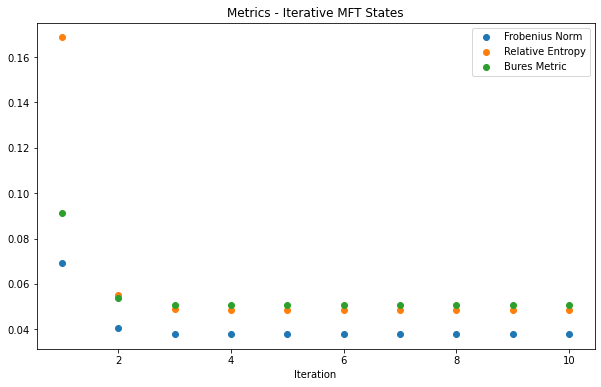

In [11]:
fig0, ax0 = plt.subplots(figsize=(10,6))
plt.title("Metrics - Iterative MFT States")

plt.scatter(iteration, frobenius_norm, label = "Frobenius Norm")
plt.scatter(iteration, relentr, label = "Relative Entropy")
plt.scatter(iteration, bures_dist, label = "Bures Metric")

ax0.legend(loc=0)
plt.xlabel("Iteration")
plt.show()

# Dependence with dimension

In [183]:
number_of_spins = [i for i in range(3, 8)]
number_of_spins_index = [number_of_spins.index(N) for N in number_of_spins]

In [184]:
list_of_spin_ops = [su2.one_body_spin_ops(N) for N in number_of_spins]
list_of_identity_ops = [list_of_spin_ops[k][0] for k in range(len(number_of_spins))]

list_of_sx_lists = [list_of_spin_ops[k][1] for k in range(len(number_of_spins))]
list_of_sy_lists = [list_of_spin_ops[k][2] for k in range(len(number_of_spins))]
list_of_sz_lists = [list_of_spin_ops[k][3] for k in range(len(number_of_spins))]

In [185]:
random_no_list = [[np.random.rand() for i in range(N)] for N in number_of_spins]

In [186]:
sum(random_no_list[0][i] * list_of_sx_lists[0][i] for i in range(3))

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.         0.41573732 0.01551187 0.         0.23625196 0.
  0.         0.        ]
 [0.41573732 0.         0.         0.01551187 0.         0.23625196
  0.         0.        ]
 [0.01551187 0.         0.         0.41573732 0.         0.
  0.23625196 0.        ]
 [0.         0.01551187 0.41573732 0.         0.         0.
  0.         0.23625196]
 [0.23625196 0.         0.         0.         0.         0.41573732
  0.01551187 0.        ]
 [0.         0.23625196 0.         0.         0.41573732 0.
  0.         0.01551187]
 [0.         0.         0.23625196 0.         0.01551187 0.
  0.         0.41573732]
 [0.         0.         0.         0.23625196 0.         0.01551187
  0.41573732 0.        ]]

In [187]:
list_of_Kamiltonians = []

for N in number_of_spins:
    n = number_of_spins.index(N)
    K_N = J * sum(random_no_list[n][m] * list_of_sx_lists[n][m] * list_of_sx_lists[n][(m+1) % N]
                             + random_no_list[n][m] * list_of_sy_lists[n][m] * list_of_sy_lists[n][(m+1) % N]
                             + random_no_list[n][m] * list_of_sz_lists[n][m] * list_of_sz_lists[n][(m+1) % N]
                 for m in range(len(random_no_list[n])))
    list_of_Kamiltonians.append(K_N)

list_of_rho0s = [safe_expm_and_normalize(K_N) for K_N in list_of_Kamiltonians]

In [224]:
mft_basis = list_of_sz_lists

list_of_guesstimates = []
for N in number_of_spins:
    n = number_of_spins.index(N)
    local_list = [-.5] + [0 for i in range(len(list_of_sx_lists[n]) - 1)]
    list_of_guesstimates.append(local_list)

list_of_trial_Ks = []
for N in number_of_spins:
    n = number_of_spins.index(N)
    trial_K = sum(zeta * op for zeta, op in zip(random_no_list[n], mft_basis[n]))
    list_of_trial_Ks.append(trial_K)
    

iteration = [i for i in range(1, 11)]
list_of_list_mftstates = [mean_field_iteration(rho0 = list_of_rho0s[n], 
                                               guesstimates = list_of_guesstimates[n],
                                                 basis = mft_basis[n], steps = 10)
                         for n in number_of_spins_index]

In [225]:
frobenius_norm = [[linalg.norm(list_of_rho0s[n] - sigma0i) for sigma0i in list_of_list_mftstates[n]] 
                          for n in number_of_spins_index]

relentr = [[rel_entropy(list_of_rho0s[n], sigma0i, svd = True) for sigma0i in list_of_list_mftstates[n]] 
                   for n in number_of_spins_index]

bures_dist = [[bures(list_of_rho0s[n], sigma0i, svd = True) for sigma0i in list_of_list_mftstates[n]] 
                   for n in number_of_spins_index[:4]]


In [226]:
[number_of_spins[n] for n in number_of_spins_index[:4]]

[3, 4, 5, 6]

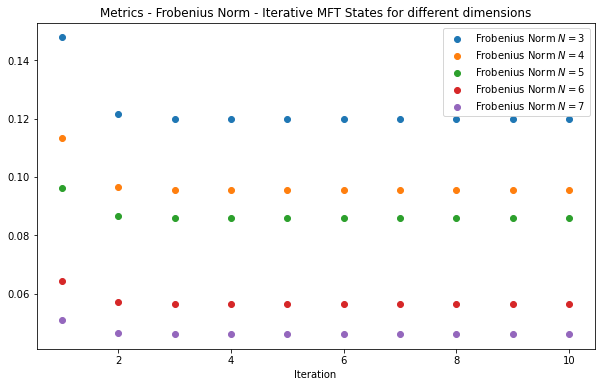

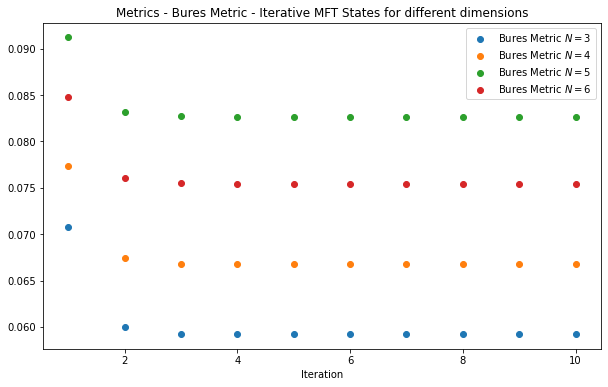

In [227]:
fig0, ax0 = plt.subplots(figsize=(10,6))
plt.title("Metrics - Frobenius Norm - Iterative MFT States for different dimensions")

for n in number_of_spins_index:
    plt.scatter(iteration, frobenius_norm[n], label = r'Frobenius Norm $N = %d$'%number_of_spins[n])

ax0.legend(loc=0)
plt.xlabel("Iteration")
plt.show()

fig1, ax1 = plt.subplots(figsize=(10,6))
plt.title("Metrics - Bures Metric - Iterative MFT States for different dimensions")

for n in number_of_spins_index[:4]:
    plt.scatter(iteration, bures_dist[n], label = r'Bures Metric $N = %d$'%number_of_spins[n])

ax1.legend(loc=0)
plt.xlabel("Iteration")
plt.show()

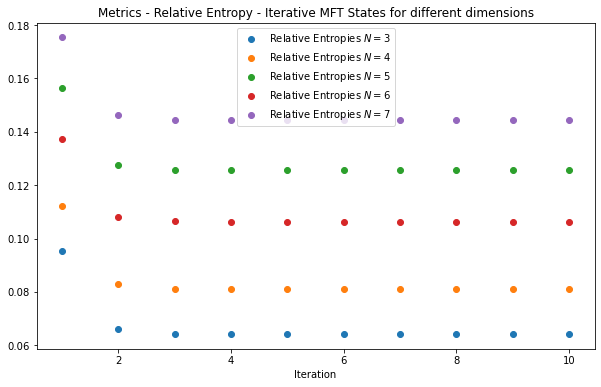

In [228]:
fig0, ax0 = plt.subplots(figsize=(10,6))
plt.title("Metrics - Relative Entropy - Iterative MFT States for different dimensions")

for n in number_of_spins_index:
    plt.scatter(iteration, relentr[n], label = r'Relative Entropies $N = %d$'%number_of_spins[n])

ax0.legend(loc=0)
plt.xlabel("Iteration")
plt.show()

In [ ]:
1. Que pasa si uso un mal estado?
2. Que pasa si uso coeficientes no aleatorios? Lejos y cercanos
3. Como se ve en la metrica KMB y la rel entr
4. Donde entra en juego las bases jerárquicas?
5. Que pasa si uso otros estados??